In [1]:
import numpy as np
from plotnine import *
from pulp import COIN_CMD
from wurlitzer import sys_pipes

import UCP.input.parser as ucp_parser
import UCP.model.ucp as original_model
import UCP.output.check_solution as ck
from generic.optimization.dual.algorithms.cutting_plane import *
from generic.optimization.dual.algorithms.subgradient import *
from generic.optimization.dual.combined_algorithm import (
    AlgorithmConfiguration,
    BoundsTracker,
    CombinedAlgorithm,
    KpiCollector,
)
from generic.optimization.dual.combined_algorithm import charts as algo_charts
from generic.optimization.dual.combined_algorithm import extract_kpis, pretty_printer
from generic.optimization.solution_extraction import extract_solution
from generic.series_dict import series_dict_to_array
from UCP.output import charts
from UCP.relaxations.combinatorial_heuristic import combinatorial_heuristic
from UCP.relaxations.local_search_heuristic import local_search
from UCP.relaxations.lagrangian.production_state.relaxation import (
    ProductionStateRelaxation,
)

In [2]:
theme_set(theme_bw() + theme(figure_size=(10, 10 / 1.61)))

In [3]:
data = ucp_parser.read_instance("./UCP/data/instance_5g.ucp")

## Full optimization with Solver

In [4]:
ucp = original_model.create_model(data)
with sys_pipes():
    ucp.model.solve(solver=COIN_CMD(mip=1, options=["node depth seconds 180"]))

optimal_cost = optimal_value = ucp.model.objective.value()
print(f"Cost: {optimal_cost}")

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - cbc /tmp/3b0aa226900f4265b33e8784a458a514-pulp.mps node depth seconds 180 branch printingOptions all solution /tmp/3b0aa226900f4265b33e8784a458a514-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1909 COLUMNS
At line 8911 RHS
At line 10816 BOUNDS
At line 11537 ENDATA
Problem MODEL has 1904 rows, 1008 columns and 5033 elements
Coin0008I MODEL read with 0 errors
Option for nodeStrategy changed from fewest to depth
seconds was changed from 1e+100 to 180
Continuous objective value is 137513 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 271 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 146 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 38 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 36 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 34 strengthened rows, 0 s

# Optimization with Lagrangian Decomposition

## Setup

In [5]:
relaxation = ProductionStateRelaxation(data)

var_lb, var_ub = tuple(
    series_dict_to_array(**m)
    for m in relaxation.multipliers_range()
)

In [6]:
upper_bound = np.nan

lower_cost_estimate = data.loads["value"].sum() * data.thermal_plants["l_cost"].min()

fixed_tracker = FixedTargetTracker(sense=-relaxation.sense, overestimation_factor=0.25)

bounds_tracker = BoundsTracker(sense=relaxation.sense)

def target_tracker(current_value: float) -> float:
    upper_bound = bounds_tracker.best_primal_solution.objective
    if abs(upper_bound - current_value) / abs(current_value + 1e-3) > 0.2:
        fixed_target = fixed_tracker(current_value)
        result = max(fixed_target, lower_cost_estimate)
    else:
        result = upper_bound
    current_target = result
    return result

In [7]:
sgd_algorithm_conf  = dict(
            sense=-relaxation.sense,
            var_lb=var_lb,
            var_ub=var_ub,
            step_size_fun=PolyakStepSizeRule(-relaxation.sense, target_tracker),
            deflection_fun=make_CFMDeflection(),
        )

In [8]:
cp_algorithm_config = dict(sense=-relaxation.sense, var_lb=var_lb, var_ub=var_ub)

In [9]:
def run_heuristic(primal_solutions):
    mip = 0
    commitments = [ps["s"] for ps in primal_solutions]
    solution = combinatorial_heuristic(
        data,
        commitments,
        combination_options=dict(
            mip=mip, options=["ratio", "0.05", "sec", "40", "doh", "node depth"]
        ),
    )
    solution = local_search(data, solution, options=["ratio", "0.05", "sec", "40", "doh", "node depth"])
    print(
        f" => Heuristic:\tTotal cost: {solution['total_production_cost']:15.5g}\t"
        + f"Demand mismatch cost:{solution['demand_mismatch_cost']:15.5g}"
    )
    return relaxation.information_from_primal_solution(solution)

## Initialization

In [10]:
configuration = AlgorithmConfiguration(
    primal_feasibility_tolerance=1e-4,
    subgradient_tolerance=1e-6,
    sgd_iterations=4,
    cp_iterations=1,
    heuristic_frequency=6,
    max_gap=0.025,
    max_cp_gap=0.01,
    relaxation_solver_options={},
    cp_solver_options={"options": ["seconds 60"]},
    max_iterations=24,
    sgd_name="Polyak+CFM",
    cp_name="CPM",
)

In [11]:
initial_multipliers = relaxation.fill_multipliers(0.0)

bounds_tracker.reset()
fixed_tracker.reset()

combined_algorithm = CombinedAlgorithm(
    configuration,
    relaxation,
    initial_multipliers,
    cp_algorithm_config,
    sgd_algorithm_conf,
    run_heuristic,
    bounds_tracker=bounds_tracker,
)

## Execution

In [12]:
kpi_collector = KpiCollector()
print(pretty_printer.header() + f"|{'Gap% from Optimum*':>25}")
stop = False
while not stop:
    stop = combined_algorithm()
    kpi_collector.collect(combined_algorithm)
    print(
        pretty_printer.row(kpi_collector)
        + f"|{abs(1- (bounds_tracker.best_primal_solution.objective/optimal_value)):>25.2%}"
    )
    
print("\n* Note: the column 'Gap% from Optimum*' is reported here only for sake of explanation as in most settings the true value of the optimum is not known beforehand.")

| It.|    Dual Algorithm|   Current Dual|    Current Master|      Best Dual|    Best Primal|       Best Master|Optimality Gap%|        CP Gap%|       Gap% from Optimum*
|   0|              None|     1.1202e+05|               inf|     1.1202e+05|            inf|               inf|        100.00%|        100.00%|                     inf%
|   1|        Polyak+CFM|     1.2217e+05|               inf|     1.2217e+05|            inf|               inf|        100.00%|        100.00%|                     inf%
|   2|        Polyak+CFM|     1.3052e+05|               inf|     1.3052e+05|            inf|               inf|        100.00%|        100.00%|                     inf%
|   3|        Polyak+CFM|     1.3138e+05|               inf|     1.3138e+05|            inf|               inf|        100.00%|        100.00%|                     inf%
|   4|        Polyak+CFM|       1.31e+05|               inf|     1.3138e+05|            inf|               inf|        100.00%|        100.00%|            

Current cost: 1.9e+05. Demand mismatch cost:5.8e+04
New cost: 1.6e+05.New demand mismatch cost:2.7e+04. Improvement: 14.50%


 => Heuristic:	Total cost:       1.633e+05	Demand mismatch cost:          26737
|   6|        Polyak+CFM|    -7.2561e+05|        9.3958e+05|     1.3138e+05|      1.633e+05|        9.3958e+05|         19.55%|         86.02%|                   17.14%
|   7|        Polyak+CFM|    -4.1647e+05|        9.3958e+05|     1.3138e+05|      1.633e+05|        9.3958e+05|         19.55%|         86.02%|                   17.14%
|   8|        Polyak+CFM|    -2.7452e+05|        9.3958e+05|     1.3138e+05|      1.633e+05|        9.3958e+05|         19.55%|         86.02%|                   17.14%
|   9|        Polyak+CFM|    -1.7538e+05|        9.3958e+05|     1.3138e+05|      1.633e+05|        9.3958e+05|         19.55%|         86.02%|                   17.14%
|  10|               CPM|    -1.0968e+06|         1.633e+05|     1.3138e+05|      1.633e+05|         1.633e+05|         19.55%|         19.55%|                   17.14%
|  11|        Polyak+CFM|    -7.2337e+05|         1.633e+05|     1.3138e+05

Current cost: 1.6e+05. Demand mismatch cost:2.5e+04
New cost: 1.4e+05.New demand mismatch cost:   96. Improvement: 12.80%


 => Heuristic:	Total cost:      1.4222e+05	Demand mismatch cost:         96.156
|  12|        Polyak+CFM|    -4.2034e+05|         1.633e+05|     1.3138e+05|     1.4222e+05|         1.633e+05|          7.62%|         19.55%|                    2.02%
|  13|        Polyak+CFM|    -2.7463e+05|         1.633e+05|     1.3138e+05|     1.4222e+05|         1.633e+05|          7.62%|         19.55%|                    2.02%
|  14|        Polyak+CFM|    -1.4594e+05|         1.633e+05|     1.3138e+05|     1.4222e+05|         1.633e+05|          7.62%|         19.55%|                    2.02%
|  15|               CPM|    -4.5866e+05|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  16|        Polyak+CFM|     -4.057e+05|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  17|        Polyak+CFM|    -3.3619e+05|        1.4222e+05|     1.3138e+05

Current cost: 2.1e+05. Demand mismatch cost:7.7e+04
New cost: 1.6e+05.New demand mismatch cost:1.9e+04. Improvement: 24.12%


 => Heuristic:	Total cost:       1.583e+05	Demand mismatch cost:          19069
|  18|        Polyak+CFM|    -1.8001e+05|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  19|        Polyak+CFM|    -1.3756e+05|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  20|               CPM|          49737|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  21|        Polyak+CFM|          57852|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  22|        Polyak+CFM|          64564|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  23|        Polyak+CFM|          72867|        1.4222e+05|     1.3138e+05

Current cost: 2.1e+05. Demand mismatch cost:8.3e+04
New cost: 1.5e+05.New demand mismatch cost:1.5e+04. Improvement: 27.75%


 => Heuristic:	Total cost:      1.5245e+05	Demand mismatch cost:          14942
|  24|        Polyak+CFM|          60054|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%

* Note: the column 'Gap% from Optimum*' is reported here only for sake of explanation as in most settings the true value of the optimum is not known beforehand.


## Output

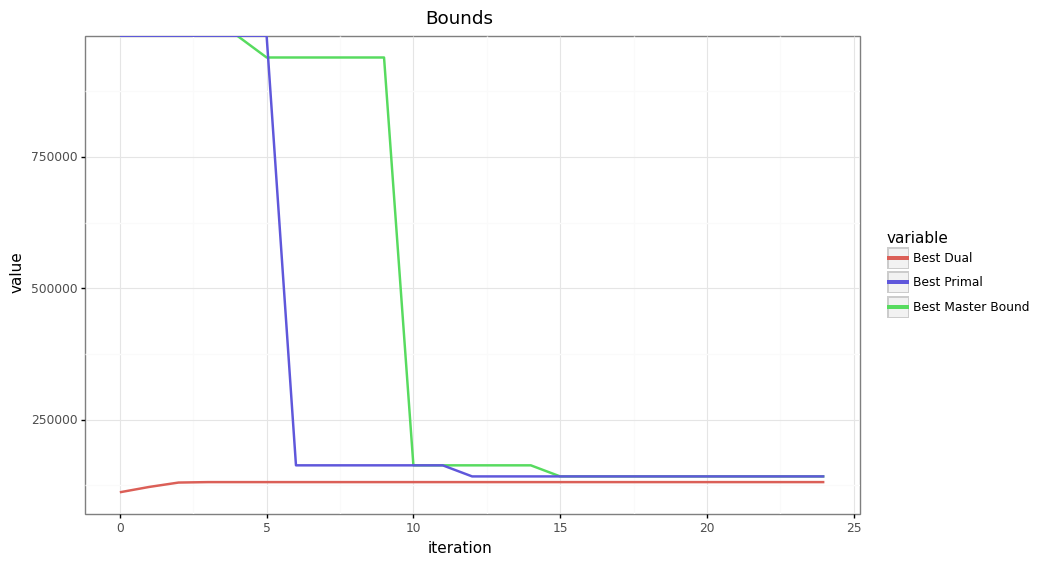

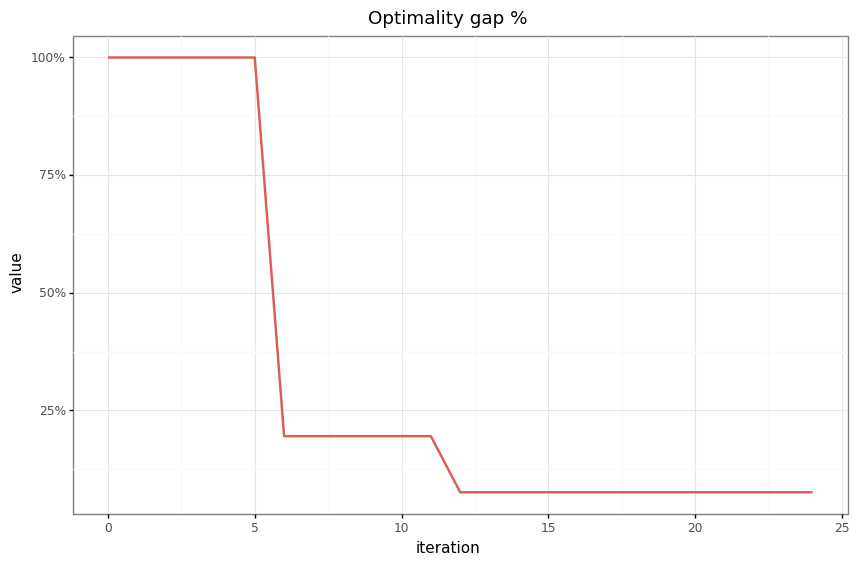

In [13]:
kpis = extract_kpis(kpi_collector.table())
print(algo_charts.bounds(kpis))
print(algo_charts.gap(kpis))

In [14]:
solution = bounds_tracker.best_primal_solution.solution

In [15]:
feasible, analysis = ck.check_solution(data, solution)
assert feasible, "ERROR: final solution is infeasible."

In [16]:
data.thermal_plants.columns

Index(['plant', 'q_cost', 'l_cost', 'c_cost', 'min_power', 'max_power',
       'init_status', 'min_on', 'min_off'],
      dtype='object')

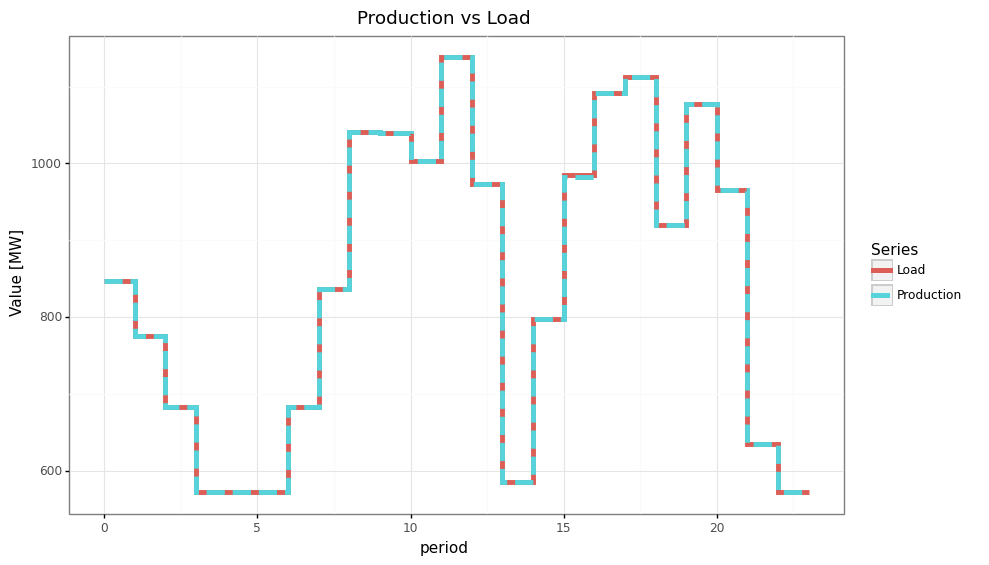

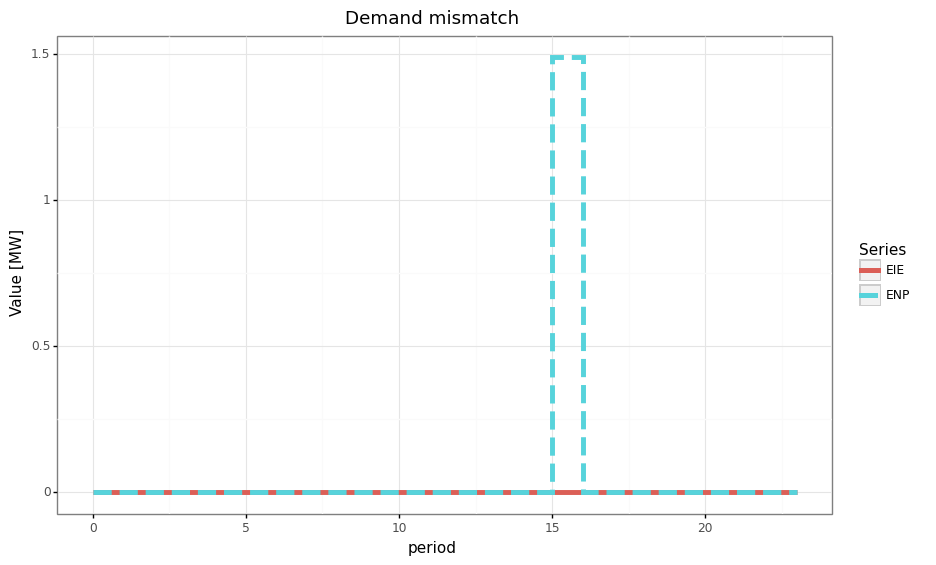

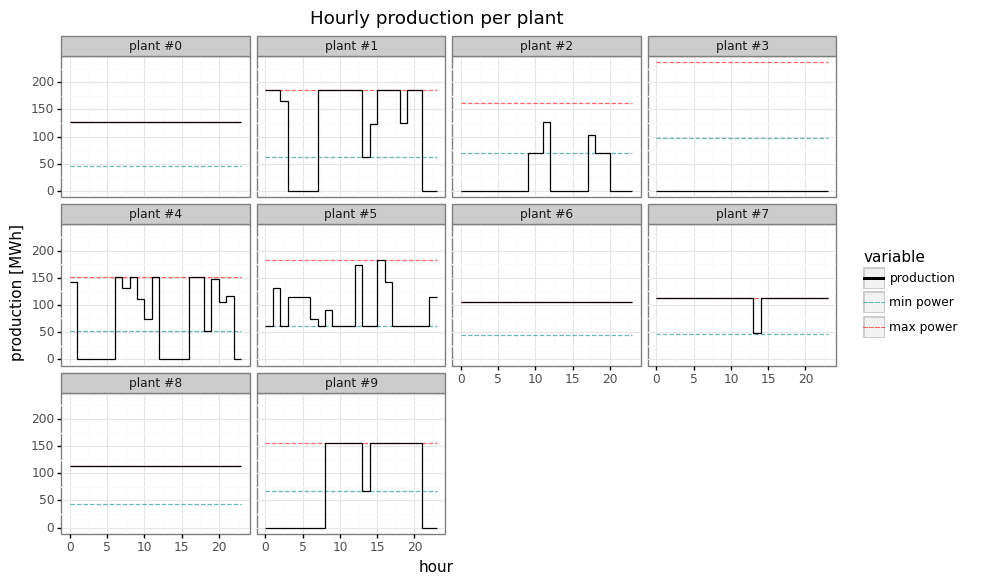

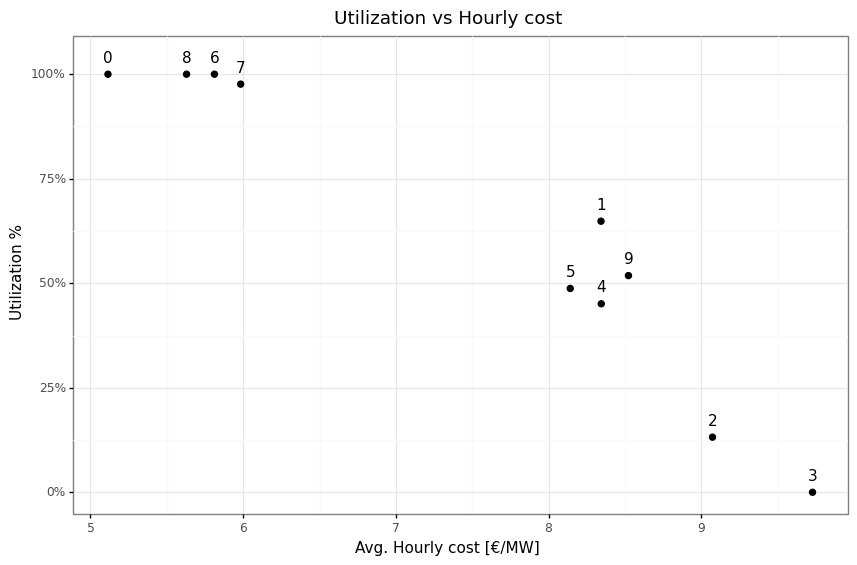

In [17]:
plots = [
    charts.total_production(data, solution),
    charts.enp_vs_eie(data, solution),
    charts.production_by_plant(data, solution),
    charts.plant_utilization(data, solution),
]

for p in plots:
    print(p)